<a href="https://colab.research.google.com/github/SidPic/Sber-Tech/blob/main/sber_tech_xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### TODO
  - сделать функции для подсчёта суммарной длительности (дата конца (нужно тоже где-то пересчитывать) - дата начала в днях), количества исполнителей и стоимости
    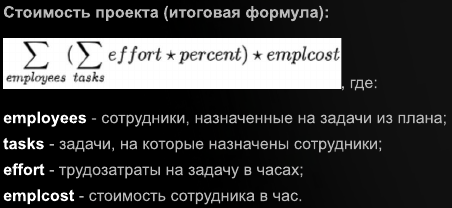
  - сделать функции для оптимизации по длительности, затратам и ресурсам (так проще будет - мы будем смотреть на один параметр: для ресурсов, например, нужно ипользовать минимум исполнителей, для длительности - по максимуму, для затрат - самых дешёвых)

  Потом можно будет сделать обработку аргументов (командной строки, как я понял), и, в зависимости от них, применять ту или иную функцию (несколько функций).

  Если останется время заморочимся с весами параметров.

#### Подготовка XML
[об xml](https://docs.python.org/3/library/xml.etree.elementtree.html#xpath-support); файл [исходные данные.xml](https://disk.yandex.ru/d/AiLyKe1DrpY67w/обновления%20после%20q%26a%20сессии/Новые%20исходные%20данные.zip) нужно перетащить в "файлы" на панели слева

In [ ]:
import xml.etree.cElementTree as ET

# Загрузка xml и пространства имён
data = ET.parse("проверочное задание.xml")
root = data.getroot()
xmlns = {'M': 'http://schemas.microsoft.com/project'}

# шорткат для получения поля
def getfield(root: ET.Element, s: str):
  return root.find(f'M:{s}', xmlns)

#### Получение полей для работы
[datetime](https://pythonru.com/primery/kak-ispolzovat-modul-datetime-v-python#Другие-арифметические-операции-с-timedelta), [pdf от сбер-теха](https://docs.yandex.ru/docs/view?url=ya-disk-public%3A%2F%2FgD8PC%2Bk9Xp56DUqSNy25Z3mxTC0H79J1MuQ4wbQmj9xMQ8cK47IPcP%2Bn%2BpaxXAmpq%2FJ6bpmRyOJonT3VoXnDag%3D%3D%3A%2Fобновления%20после%20q%26a%20сессии%2FОптимизация_плана_проекта_v2.pdf&name=Оптимизация_плана_проекта_v2.pdf)


In [ ]:
from datetime import datetime

# переводит строковую дату в datetime
def str_to_date(s: str):
  return datetime.strptime(s, '%Y-%m-%dT%H:%M:%S')

# переводит datetime в строку
def date_to_str(date: datetime):
  return date.strftime('%Y-%m-%dT%H:%M:%S')

# поля
START_DATE  = str_to_date(getfield(root, "StartDate").text)
tasks       = getfield(root, "Tasks")
calendar    = getfield(root, "Calendars")[0]
resources   = getfield(root, "Resources")
bindings    = getfield(root, "Assignments") # привязки ресурсов и задач

#### Методы календаря
[поля календаря](https://learn.microsoft.com/ru-ru/office-project/xml-data-interchange/calendar-elements-and-xml-structure?view=project-client-2016)

In [ ]:
# возвращает булево значение, рабочий день или нет
def is_working(date: str):
  if str_to_date(date).weekday() >= 5: # суббота, воскресенье
    return False

  weekends = calendar.findall(".//M:TimePeriod/*", xmlns)

  for weekend in weekends:
    if date[:10] == weekend.text[:10]: # 2024-01-01 дата - первые 10 символов
      return False

  return True

def is_working(date: datetime):
  if date.weekday() >= 5: # суббота, воскресенье
    return False

  weekends = calendar.findall(".//M:TimePeriod/*", xmlns)
  date = date_to_str(date)[:10]

  for weekend in weekends:
    if date == weekend.text[:10]: # 2024-01-01 дата - первые 10 символов
      return False

  return True

#### Методы задач
[поля задачи](https://learn.microsoft.com/ru-ru/office-project/xml-data-interchange/task-elements-and-xml-structure?view=project-client-2016)

In [ ]:
from datetime import timedelta

# возвращает задачу, от которой зависит данная, если таковой нет - None
def get_predecessor(task: ET.Element):
  link = getfield(task, "PredecessorLink")
  if link is None:
    return None

  return tasks[int(getfield(link, "PredecessorUID").text)]

# возвращает задачу, подзадачей которой является данная, если таковой нет - None
def get_parent(task: ET.Element):
  h_num = getfield(task, "OutlineNumber").text # номер в иерархии
  if len(h_num) == 1:
   return None

  n = len(h_num)-1
  while h_num[n] != '.':
    n -= 1

  return tasks.find(f"./M:Task/M:OutlineNumber[.='{h_num[:n]}']..", xmlns)

# возвращает зависимые задачи
def get_dependents(task: ET.Element):
  UID = getfield(task, "UID").text
  return tasks.findall(f"./M:Task/M:PredecessorLink/M:PredecessorUID[.='{UID}']../..", xmlns)

# возвращает 1 уровень подзадач ([tasks])
def get_childs(task: ET.Element, without_deps: bool):
  H_num = getfield(task, "OutlineNumber").text

  next_id = int(getfield(task, "UID").text)+1;
  if next_id >= len(tasks):
    return []

  childs = []
  for t in tasks[next_id:]:
    if without_deps:
      if getfield(t, "PredecessorLink") != None:
        continue

    h_num = getfield(t, "OutlineNumber").text
    if len(h_num) == 1:
      continue

    n = len(h_num)-1
    while h_num[n] != '.':
      n -= 1

    if h_num[:n] == H_num:
      childs.append(t)

  return childs

# возвращает необходимую роль исполнителя задачи
def get_employee(task: ET.Element):
  return getfield(task, "Name").text[:4]

# возвращает общую трудоёмкость задачи (часов)
def get_duration(task: ET.Element):
  s = getfield(task, "Duration").text[2:]
  n = 0
  while s[n] != 'H':
    n += 1

  return int(s[:n])

# перемещает начало задачи в date, учитывает все зависимости
def move(task: ET.Element, start_date: datetime):
  start = getfield(task, "Start")
  finish = getfield(task, "Finish")
  duration = get_duration(task) / 8 # в рабочем дне 8 часов
  finish_date = start_date + timedelta(hours=9)

  while not is_working(start_date) or start_date < START_DATE:
    start_date += timedelta(days=1)

  while duration > 1:
    finish_date += timedelta(days=1)
    while not is_working(finish_date):
      finish_date += timedelta(days=1)

    duration -= 1

  start.text = date_to_str(start_date)
  finish.text = date_to_str(finish_date)

  for ch in get_childs(task, without_deps=True):
    move(ch, start_date)

  for dep in get_dependents(task):
    move(dep, finish_date + timedelta(hours=15)) # 24 - 9 = 15

#### Методы ресурсов
[поля ресурса](https://learn.microsoft.com/ru-ru/office-project/xml-data-interchange/resource-elements-and-xml-structure?view=project-client-2016)

In [ ]:
# возвращает emplcost - стоимость сотрудника (руб/ч)
def get_emplcost(resource: ET.Element):
  s = getfield(resource, "Name").text
  s_len = len(s)

  n = 0
  while n < s_len and s[n] != '(':
    n += 1

  if n == s_len:
    return 0

  n += 1
  m = n
  while s[m].isdigit():
    m += 1

  return int(s[n:m])

# возвращает роль сотрудника
def get_role(resource: ET.Element):
  role = resource.find("./M:ExtendedAttribute/M:FieldID[.='205521131']../M:Value", xmlns)
  if role is None:
    return ''
  return role.text[:4]

# возвращает дату окончания последней задачи
def last_work(res: ET.Element):
  lw = datetime(1, 1, 1)
  for b in bindings:
    if getfield(b, "ResourceUID") == getfield(res, "UID"):
      task = tasks[int(getfield(b, "TaskUID").text)]
      finish = str_to_date(getfield(task, "Finish").text)
      if lw < finish:
        lw = finish

  return lw

#### Привязка
[поля привязки](https://learn.microsoft.com/ru-ru/office-project/xml-data-interchange/assignment-elements-and-xml-structure?view=project-client-2016) (нужны TaskUID и ResourceUID)

In [ ]:
# очистка привязок
for b in bindings:
  getfield(b, "ResourceUID").text = ''

# привязывает сотрудника к задаче, если это возможно, возвращает булево значение
# без учёта ролей (релизован непосредственно в алгоритме)
def bind(task: ET.Element, res: ET.Element):
  taskUID = getfield(task, "UID").text
  resUID = getfield(res, "UID").text

  start = str_to_date(getfield(task, "Start").text)
  finish = str_to_date(getfield(task, "Finish").text)

  found = False
  bnd = ET.Element('')
  for b in bindings:
    otherUID = getfield(b, "TaskUID").text
    if otherUID == taskUID:
      if get_employee(task) != get_role(res):
        return False
      bnd = b
      found = True

    if getfield(b, "ResourceUID").text == resUID:
      other = tasks[int(otherUID)]
      other_start = str_to_date(getfield(other, "Start").text)
      other_finish = str_to_date(getfield(other, "Finish").text)

      if other_start <= start and start <= other_finish\
      or other_start <= finish and finish <= other_finish:
        return False

  if not found:
    return False

  getfield(bnd,"ResourceUID").text = resUID

  return True

#### Предоптимизация

In [ ]:
# изначально устанавливается наименьшая длительность проекта
move(tasks[0], START_DATE)

# подготавливается массив ресурсов, отсортированных по цене
sorted_resources = sorted(resources.findall("./M:Resource", xmlns), key=lambda res: get_emplcost(res))


#### Оптимизация

In [ ]:
# оптимизирует по длительности,
# если max_employees, max_cost указаны >= 0 - оптимизирует по этим параметрам тоже
def optimize(max_employees: int = -1, max_cost: int = -1):
  if max_employees < -1:
    max_employees = -1
  if max_cost < -1:
    max_cost = -1
  co = (max_cost == -1)

  for task in tasks:
    role = get_employee(task)
    if role == '':
      continue

    binded = False
    role_found = False
    for res in sorted_resources:
      if get_role(res) == role:
        role_found = True

        if max_employees != 0 and max_cost != 0:
          if bind(task, res):
            binded = True
            max_employees -= 1
            max_cost -= get_duration(task) * get_emplcost(res)
            if (not co) and (max_cost < 0):
              max_cost = 0
            break
        else:
          while not bind(task, res):
            move(task, str_to_date(getfield(task, "Start").text) + timedelta(days=1))
          binded = True
          break

    if not role_found:
      continue

    if not binded:
      min_busy = ET.Element('')
      min_lw = datetime(3000, 1, 1)
      for res in sorted_resources:
        if get_role(res) == role:
          lw = last_work(res)
          if lw < min_lw:
            min_lw = lw
            min_busy = res

      while not bind(task, min_busy):
        move(task, str_to_date(getfield(task, "Start").text) + timedelta(days=1))
      max_employees -= 1
      max_cost -= get_duration(task) * get_emplcost(min_busy)
      if (not co) and (max_cost < 0):
        max_cost = 0

#### Main

In [ ]:
# оптимизация
# optimize() # по длительности
# optimize(max_employees=6) # по ресурсам (max 6 человек)
# optimize(max_cost=2000000) # по стоимости (max 2 000 000 рублей)
optimize(max_employees=7, max_cost=2000000) # по всем параметрам

data.write("по всем параметрам(установлен максимум 7 человек и 2млн р).xml", encoding="UTF-8", xml_declaration=True, default_namespace=xmlns['M'])